# standadizer.py

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

from PIL import Image
import os

def resize_and_standardize_images(input_dir, output_dir, size=(128, 128)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        try:
            if filename.endswith((".jpg", ".png", ".jpeg","JPG","bmp","PNG")):  # Added ".jpeg" to the tuple
                print(f"Processing {filename}")
                img = Image.open(os.path.join(input_dir, filename))
                if img.mode == 'P':
                    img = img.convert('RGBA')
                img = img.resize(size, Image.LANCZOS)
                img = img.convert('RGB')
                img.save(os.path.join(output_dir, filename))
        except Exception as e:
            print(f"Error processing {filename}: {e}")


# Usage
input_dir = "/content/drive/MyDrive/dom/non_standadized"
output_dir = "/content/drive/MyDrive/dom/min_data"
resize_and_standardize_images(input_dir, output_dir)

Processing first_glimpse.jpg
Processing baby1.jpg
Processing ultrasound-baby-mothers-womb-260nw-546641992.jpg
Processing Photo-1B.png
Processing early_scan_pic_1024x1024a_025bcb24-41f8-443d-b2b4-27437dd8ccb1_1024x1024.jpg
Processing 13-Weeks-Pregnant-Ultrasound.png
Processing blog_Oct_24_2017_pregnancy-ultrasound-scary.jpg
Processing ultrasound-baby-five-month-33362661.jpg
Processing us1-329x250.jpg
Processing images - 2024-04-05T102003.882.jpeg
Processing a-2nd-trimester-baby-boy-ultrasound-scan-mothers-name-digitally-removed-FTE31D.jpg
Processing images - 2024-04-05T102004.122.jpeg
Processing images - 2024-04-05T102004.073.jpeg
Processing Fetal_Ultrasound_Face with placenta (gray mass to left)_image from N Fornell.jpeg
Processing baby-head-on-ultrasound-scan-in-hospital-check-ME3683.jpg
Processing A_1017_baby-scan_B2RR84.width-320.jpg
Processing images - 2024-04-05T102005.122.jpeg
Processing images - 2024-04-05T102005.024.jpeg
Processing ddpb21420wsca_013.jpg
Processing images - 2024

KeyboardInterrupt: 

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

## Load the files

In [8]:
BASE_DIR = '/content/drive/MyDrive/dom/train/down_syndrome'

In [9]:
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [10]:
image_paths[:5]

['/content/drive/MyDrive/dom/train/down_syndrome/557.png',
 '/content/drive/MyDrive/dom/train/down_syndrome/644.png',
 '/content/drive/MyDrive/dom/train/down_syndrome/545.png',
 '/content/drive/MyDrive/dom/train/down_syndrome/680.png',
 '/content/drive/MyDrive/dom/train/down_syndrome/539.png']

In [11]:
# remove unnecessary file
# image_paths.remove('data/data')

In [12]:
len(image_paths)

1373

## Visualize the Image Dataset

In [13]:
# to display grid of images (7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

Output hidden; open in https://colab.research.google.com to view.

## Preprocess Images

In [25]:
# load the image and convert to numpy array
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
# train_images = np.array(train_images)

  0%|          | 0/1373 [00:00<?, ?it/s]

In [26]:
from skimage.transform import resize

In [27]:
train_images = [resize(image, (64, 64, 3)) for image in train_images]
train_images = np.array(train_images)

In [28]:
train_images[0].shape


(64, 64, 3)

In [29]:
# reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [30]:
# normalize the images
train_images = (train_images - 127.5) / 127.5

In [31]:
train_images[0]

array([[[-0.998568  , -0.998568  , -0.99850726],
        [-0.99764353, -0.9976444 , -0.99760395],
        [-0.99829364, -0.99830496, -0.9981935 ],
        ...,
        [-0.9982516 , -0.99822843, -0.998069  ],
        [-0.9983083 , -0.99828064, -0.99815905],
        [-0.9991294 , -0.99912244, -0.9990471 ]],

       [[-0.99898785, -0.9989919 , -0.9989149 ],
        [-0.99848646, -0.9984915 , -0.9984317 ],
        [-0.99892217, -0.9989343 , -0.99881405],
        ...,
        [-0.9976722 , -0.9976549 , -0.99749905],
        [-0.99754184, -0.9975182 , -0.99740463],
        [-0.9985869 , -0.998581  , -0.9985075 ]],

       [[-0.99940646, -0.9994257 , -0.99930006],
        [-0.99899393, -0.9990144 , -0.99889   ],
        [-0.9989156 , -0.99893194, -0.9988014 ],
        ...,
        [-0.99906886, -0.9990789 , -0.99896497],
        [-0.99884105, -0.9988385 , -0.998768  ],
        [-0.99928594, -0.99928516, -0.9992221 ]],

       ...,

       [[-0.9980976 , -0.9980976 , -0.9980976 ],
        [-0

## Create Generator & Discriminator Models

In [32]:
# latent dimension for random noise
LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

### Generator Model

Generator Model will create new images similar to training data from random noise

In [33]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

### Discriminator Model

Discriminator model will classify the image from the generator to check whether it real (or) fake images.

In [34]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

## Create DCGAN

In [35]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [36]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [37]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [38]:
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
N_EPOCHS = 2000
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

## Generate New Anime Image

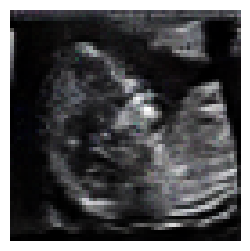

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
# plt.savefig('epoch_{:03d}.png'.format(epoch))
plt.show()